In [8]:
import pandas as pd
import numpy as np
from numpy import linalg
import math
import random
from matplotlib import pyplot as plt

# Deep Galerkin Method : Pricing de vanilles dans le modèle Black Scholes

## 0. Paramètres du modèle Black Scholes

In [9]:
TYPE = "Call"
TIME = 0
SPOT = 50
STRIKE = 120
DIVIDEND = 0
RATE = 0.05
VOLATILITY = 0.3
MATURITY = 1

## 1. Architecture du RN

Nombre de couches cachées : 1 -- Nombre de neurones par couche : 10 (egale pour toutes les couches) -- Fonction d'activation : ReLU

Fonction de coût : Norme L2 

Sample : 10000 vecteurs (t_n,x_n) -- 10 mini batchs size_batch = 1000 -- Learning rate = 0.05

Text(0, 0.5, 'stock price')

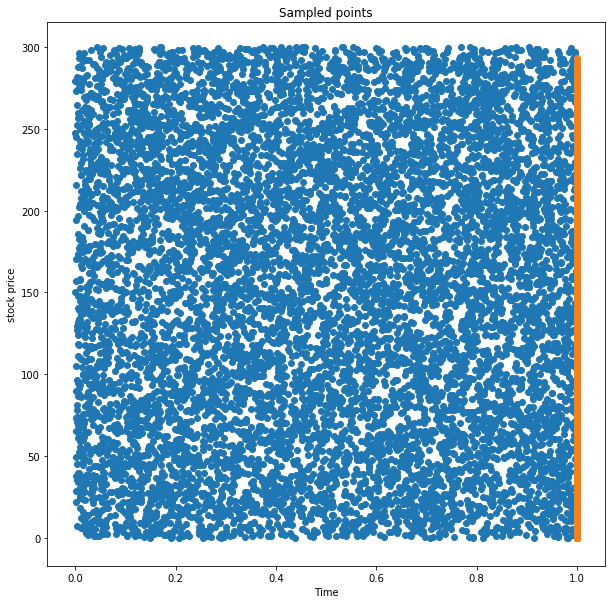

In [10]:
#Définition des variables et architecture
init_layers = {"x":[0]*10, "h1":[0]*10, "y":[0]*10}

#Inputs, hidden layer, output
x = np.array(init_layers["x"])
y = np.array(init_layers["h1"])
h1 = np.array(init_layers["y"])

#Activation function : ReLU
def phy(x):
    return max([0,x])

#Loss function 
def L2(x):
    return linalg.norm(x,2)

#Sampling
sample_size = 10000
batch_size = 1000
training_set_time = np.array([random.uniform(0,MATURITY) for i in range(sample_size)])
training_set_space = np.array([random.uniform(0,2.5*STRIKE) for i in range(sample_size)])
training_set_bound = np.array([random.uniform(0,random.uniform(0,2.5*STRIKE)) for i in range(sample_size)])

#Mini-batchs
num_of_batchs = int(sample_size/batch_size)
index_of_points = list(range(sample_size))
random.shuffle(index_of_points)
list_of_batchs = [index_of_points[i:i+batch_size] for i in range(num_of_batchs)]
batchs = [[(training_set_time[i],training_set_space[i],training_set_bound[i]) for i in index_of_batchs] for index_of_batchs in list_of_batchs]

#Visualisation of sample
plt.figure(figsize = (10,10))
plt.title('Sampled points')
plt.scatter(training_set_time,training_set_space)
plt.scatter([1]*sample_size,training_set_bound)
plt.xlabel('Time')
plt.ylabel('stock price')

## 2. Classe du réseau de neurones

In [229]:
class NeuralNetwork(CalculDiff):
    
    def __init__(self,size_input,nb_h_layers,size_h_layers,size_output):
        """
        Funtion feed forward through the NN (input : n dim, nb of hidden layers : h, nb of neurals in HL : d, output of NN: m)
        Inputs :
            size_input (int) : size of the input vector
            nb_h_layers (int) : number of hidden layers
            size_h_layers (int) : number of neurons on each layer
            size_output (int) : size of output vector (scalar if one)
        """
        self.W = None
        self.b = None
        self.dx = pow(10,-5)
        self.size_input = size_input
        self.nb_h_layers = nb_h_layers
        self.size_h_layers = size_h_layers
        self.size_output = size_output
        self.total_layers = nb_h_layers+2
        self.gradient = []
        
    def hidden(self,x,W,b):
        """
        Function from HL to HL (input : n dim, output m dim).
        Inputs :
            x (np_arr): n*1-dim column numpy vector (input of the layer)
            W (np_arr): m*n-dim numpy array of weights of the current layer
            b (np_arr): m*1-dim numpy vector
        """
        combinaison =  b + np.matmul(W,x)
        output = np.array([[phy(sum(v))] for v in combinaison])
        return output

    def feedforward(self,x):
        """
        Funtion feed forward through the NN (input : n dim)
        Inputs :
            x (np_arr): n-dim column vector (input of the NN)
        """
        output = np.array(x)
        for i in range(self.total_layers):
            output = self.hidden(output,self.W[i],self.b[i])
        return float(output)
    
    def initweight(self):
        """
        Funtion to initialize weights matrix and bias vector of the NN.
        """
        W0 = [np.array([[random.gauss(0,1) for i in range(self.size_input)] for j in range(self.size_h_layers)])]
        W0 = W0 + [np.array([[random.gauss(0,1) for i in range(self.size_h_layers)] for j in range(self.size_h_layers)])for k in range(self.nb_h_layers)]
        W0 = W0 + [np.array([[random.gauss(0,1) for i in range(self.size_h_layers)] for j in range(self.size_output)])]
        b0 = [np.array([[random.gauss(0,1)] for i in range(self.size_h_layers)]) for j in range(self.nb_h_layers+1)]
        b0 = b0 + [np.array([[random.gauss(0,1)] for i in range(self.size_output)])]
        self.W = W0
        self.b = b0
        
    def lossfunction(self,x,x_bound):
        L1 = pow(self.diff(self.feedforward,x,0) + x[1]*RATE*self.diff(self.feedforward,x,1) 
              + pow(x[1]*VOLATILITY,2)*self.diff_second(self.feedforward,x,1) + RATE*self.feedforward(x),2)
        L2 = pow(self.feedforward([MATURITY,x_bound]) - max(x_bound-STRIKE,0),2)
        return float(L1 + L2)
        
    def backpropagation(self,x)
        K = None
        return K


In [233]:
x=np.array([[1],[2]])
x_bound = 10
NN = NeuralNetwork(2,1,4,1)
NN.initweight()
NN.feedforward(x)
NN.lossfunction(x,x_bound)

[0.11815131]
2.7404328913931955


2.858584200502112

In [231]:
np.matmul(np.array([[1,1,1,1,1,1,1,1,1,1]]),np.array([[1],[1],[1],[1],[1],[1],[1],[1],[1],[1]]))

array([[10]])

## Annexe : outils numériques

In [172]:
# Outils pour le calcule differentiel 
from decimal import *
getcontext().prec = 28

class CalculDiff():
    def __init__(self):
        self.dx = pow(10,-5)
    
    def diff(self,func,variables,index_to_diff):
        variable_plus_h = variables.copy()
        variable_plus_h[index_to_diff]  = variable_plus_h[index_to_diff]+self.dx
        return float((Decimal(func(variable_plus_h))-Decimal(func(variables)) )/Decimal(self.dx))
    
    def diff_second(self,func,variables,index_to_diff):
        variable_plus_h = variables.copy()
        variable_plus_h[index_to_diff]  = variable_plus_h[index_to_diff]+self.dx
        return float(Decimal(self.diff(func,variable_plus_h,index_to_diff) - self.diff(func,variables,index_to_diff))/Decimal(self.dx))

In [235]:
pow(pow(1+0.007944,0.25)*pow(1+0.01034,0.5),1.25)-1

0.008941749556800271

In [173]:
CD = CalculDiff()
def foo(v):
    return pow(v[0],3)
print(CD.diff(foo,[1,2],0))
CD.diff_second(foo,[2,2],0)

3.000030000110953


12.000036520021238